##Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Install transformers library if not already installed
!pip install transformers
from transformers import BertTokenizer, BertModel
import nltk
nltk.download('all')
import torch
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split # Import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

##Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Loading 3 Dataset

In [3]:
amazon = pd.read_csv("/content/drive/MyDrive/Code implementations /Sentiment Analysis/amazon_cells_labelled.txt", sep='\t', names=['Review', 'Sentiment'])

In [4]:
amazon

,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


In [5]:
imdb = pd.read_csv("/content/drive/MyDrive/Code implementations /Sentiment Analysis/imdb_labelled.txt", sep='\t', names=['Review', 'Sentiment'])

In [6]:
imdb

,Review,Sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
743,I just got bored watching Jessice Lange take h...,0
744,"Unfortunately, any virtue in this film's produ...",0
745,"In a word, it is embarrassing.",0
746,Exceptionally bad!,0


In [7]:
yelp = pd.read_csv("/content/drive/MyDrive/Code implementations /Sentiment Analysis/imdb_labelled.txt", sep='\t', names=['Review', 'Sentiment'])
yelp

,Review,Sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
743,I just got bored watching Jessice Lange take h...,0
744,"Unfortunately, any virtue in this film's produ...",0
745,"In a word, it is embarrassing.",0
746,Exceptionally bad!,0


In [8]:
df = pd.concat([amazon, imdb, yelp], ignore_index=True)
df


,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
2491,I just got bored watching Jessice Lange take h...,0
2492,"Unfortunately, any virtue in this film's produ...",0
2493,"In a word, it is embarrassing.",0
2494,Exceptionally bad!,0


##EDA

In [9]:
df.shape

(2496, 2)

In [10]:
missing_values = df.isnull().sum()
print(missing_values)


Review       0
Sentiment    0
dtype: int64


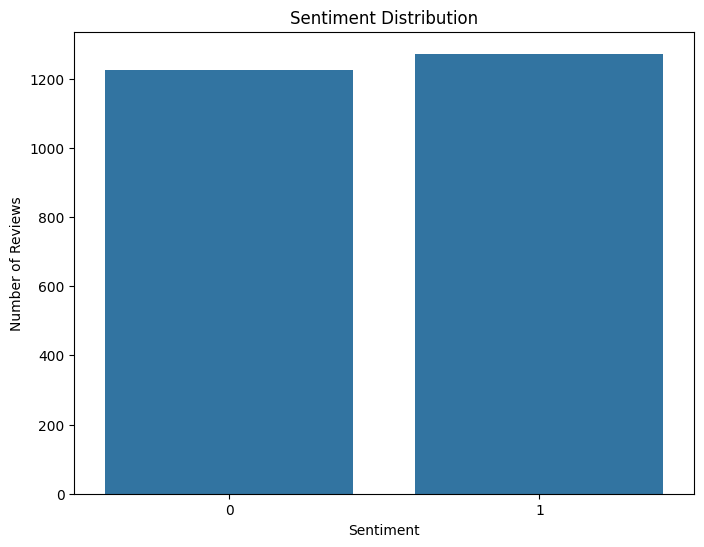

In [11]:
 #bar graph for comparison



sentiment_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

##Preprocess the Data

## Preprocess the Data

In [12]:
# prompt: Preprocess the text: lowercase conversion, remove special characters, stopwords removal, tokenization, and generate bigrams/trigrams/four-grams


stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase conversion
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Stopwords removal
    tokens = [w for w in tokens if not w in stop_words]
    # Generate n-grams
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))
    fourgrams = list(ngrams(tokens, 4))

    return tokens, bigrams, trigrams, fourgrams

# Example usage (assuming 'df' is your DataFrame)
df['tokens'], df['bigrams'], df['trigrams'], df['fourgrams'] = zip(*df['Review'].map(preprocess_text))
print(df.head())


                                              Review  Sentiment  \
0  So there is no way for me to plug it in here i...          0   
1                        Good case, Excellent value.          1   
2                             Great for the jawbone.          1   
3  Tied to charger for conversations lasting more...          0   
4                                  The mic is great.          1   

                                              tokens  \
0             [way, plug, us, unless, go, converter]   
1                     [good, case, excellent, value]   
2                                   [great, jawbone]   
3  [tied, charger, conversations, lasting, 45, mi...   
4                                       [mic, great]   

                                             bigrams  \
0  [(way, plug), (plug, us), (us, unless), (unles...   
1  [(good, case), (case, excellent), (excellent, ...   
2                                 [(great, jawbone)]   
3  [(tied, charger), (charger, conve

In [13]:
# prompt: Apply sentiment lexicon to extract sentiment-rich n-grams from the text and remove non-relevant sections

import nltk
from nltk.corpus import opinion_lexicon

# Download opinion lexicon if not already downloaded
nltk.download('opinion_lexicon')

positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

def extract_sentiment_ngrams(ngrams):
    sentiment_ngrams = []
    for ngram in ngrams:
        # Join n-grams back into strings
        ngram_str = " ".join(ngram)

        # Check for positive or negative words in the n-gram
        if any(word in positive_words for word in ngram):
            sentiment_ngrams.append((ngram_str, "positive"))
        elif any(word in negative_words for word in ngram):
            sentiment_ngrams.append((ngram_str, "negative"))
    return sentiment_ngrams


# Assuming your dataframe is named 'df'
df['sentiment_bigrams'] = df['bigrams'].apply(extract_sentiment_ngrams)
df['sentiment_trigrams'] = df['trigrams'].apply(extract_sentiment_ngrams)
df['sentiment_fourgrams'] = df['fourgrams'].apply(extract_sentiment_ngrams)


# Example of how to access sentiment n-grams for a specific review
# Reset the index of the DataFrame to ensure 0 is a valid index.
df = df.reset_index(drop=True)
print(df['sentiment_bigrams'][0])  #Prints the sentiment bigrams of the first review

# Example to remove non-relevant sections
#This will remove reviews where sentiment bigrams are empty
df = df[df['sentiment_bigrams'].map(lambda x: len(x) > 0)]
print(df.head())

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


[]
                                              Review  Sentiment  \
1                        Good case, Excellent value.          1   
2                             Great for the jawbone.          1   
3  Tied to charger for conversations lasting more...          0   
4                                  The mic is great.          1   
5  I have to jiggle the plug to get it to line up...          0   

                                              tokens  \
1                     [good, case, excellent, value]   
2                                   [great, jawbone]   
3  [tied, charger, conversations, lasting, 45, mi...   
4                                       [mic, great]   
5  [jiggle, plug, get, line, right, get, decent, ...   

                                             bigrams  \
1  [(good, case), (case, excellent), (excellent, ...   
2                                 [(great, jawbone)]   
3  [(tied, charger), (charger, conversations), (c...   
4                                

In [14]:
# prompt: Use pre-trained BERT (transformers library) to convert sentiment lexicon-selected text into vector embeddings

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Extract [CLS] token embeddings
    return embeddings

# Assuming 'df' is your DataFrame with 'sentiment_bigrams', 'sentiment_trigrams', and 'sentiment_fourgrams' columns.
# Example usage: get embeddings for sentiment bigrams of the first 5 reviews

# Use df.iterrows() to iterate through rows and access data by index:
for index, row in df.iterrows():
    if index < 5: # Limiting to first 5 reviews
        sentiment_bigrams = row['sentiment_bigrams']
        for ngram, sentiment in sentiment_bigrams:
            embeddings = get_bert_embeddings(ngram)
            print(f"N-gram: {ngram}, Sentiment: {sentiment}, Embeddings shape: {embeddings.shape}")
            print(f"Embeddings: {embeddings}") # Print the actual embeddings (optional, for demonstration)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

N-gram: good case, Sentiment: positive, Embeddings shape: (1, 768)
Embeddings: [[-5.52344397e-02  2.14961722e-01 -7.67694265e-02 -9.45844781e-03
   2.76822355e-02 -1.66661903e-01  9.57394242e-02  2.90209055e-01
  -1.08726034e-02 -3.60597968e-02 -1.74275693e-03 -1.04282387e-01
  -5.44298552e-02  5.35355546e-02 -1.01220675e-01 -1.13192447e-01
  -2.27671310e-01  1.95015430e-01  2.37035856e-01 -1.67549327e-01
  -4.48646210e-02 -2.51523376e-01 -2.01768026e-01 -1.07190564e-01
  -9.19460207e-02 -2.21204370e-01  6.00376762e-02 -1.28741935e-02
   1.37937620e-01  1.72343284e-01  2.51702845e-01 -2.30728108e-02
   3.61375883e-02  1.46460176e-01 -1.34846747e-01  7.59523269e-03
   5.27253635e-02  1.96557716e-02 -1.25767037e-01  2.26212735e-03
   5.02858236e-02 -9.29835439e-02  2.08440796e-01  6.41572252e-02
  -1.64765716e-01 -2.27415532e-01 -1.42484033e+00  1.02061126e-02
  -1.60516500e-01 -2.72249073e-01  2.04364985e-01  1.48902714e-01
   1.87036231e-01  5.50152771e-02  6.26833141e-02  1.48203999e-

In [15]:
#Build a CNN model in TensorFlow/Keras with an embedding layer (LeBERT), convolutional layers, pooling layers, dense layers, and softmax output
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input

# Define CNN model with LeBERT embeddings as input
def create_cnn_model(input_shape):
    model = Sequential([
        # Input layer (LeBERT embeddings)
        Input(shape=input_shape),

        # Convolutional layer: Extracts features from embeddings
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),

        # Pooling layer: Reduces dimensionality
        GlobalMaxPooling1D(),

        # Fully connected layer: Learns important patterns
        Dense(128, activation='relu'),
        Dropout(0.5),  # Prevents overfitting

        # Output layer: Sigmoid activation for binary classification
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Example: Assuming LeBERT embeddings have shape (max_length, embedding_dim)
embedding_dim = 128  # LeBERT output vector size
max_length = 50  # Max sequence length

cnn_model = create_cnn_model((max_length, embedding_dim))

# Display model summary
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 50, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,921 (257.50 KB)

 Trainable params: 65,921 (257.50 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Define CNN model with LeBERT embeddings as input
def create_cnn_model(input_shape):
    model = Sequential([
        # Input layer (LeBERT embeddings)
        Input(shape=input_shape),

        # Convolutional layer: Extracts features from embeddings
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),

        # Pooling layer: Reduces dimensionality
        GlobalMaxPooling1D(),

        # Fully connected layer: Learns important patterns
        Dense(128, activation='relu'),
        Dropout(0.5),  # Prevents overfitting

        # Output layer: Sigmoid activation for binary classification
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Update embedding_dim to match BERT's output size
embedding_dim = 768  # BERT-base embedding dimension
max_length = 50  # Max sequence length

# Create the CNN model with the correct embedding dimension
cnn_model = create_cnn_model((max_length, embedding_dim))

# Assuming 'df' is your DataFrame with 'sentiment_bigrams' and 'Sentiment' columns

# 1. Create a list to store embeddings and corresponding labels
all_embeddings = []
all_labels = []

# 2. Iterate through the DataFrame to extract embeddings and labels
for index, row in df.iterrows():
    sentiment_bigrams = row['sentiment_bigrams']
    label = row['Sentiment']  # Get the sentiment label for the review
    for ngram, sentiment in sentiment_bigrams:
        embeddings = get_bert_embeddings(ngram)
        all_embeddings.append(embeddings)
        all_labels.append(label)  # Append the review's label for each bigram

# 3. Convert to NumPy arrays
X = np.array(all_embeddings)
y = np.array(all_labels)

# 4. Split dataset: 80% Training, 20% Testing
from sklearn.model_selection import train_test_split # Make sure train_test_split is imported
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Pad or truncate your embeddings using pad_sequences:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad or truncate X_train
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')

# Pad or truncate X_test
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

# Now you can use X_train_padded and X_test_padded for training your CNN
cnn_model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test))

# 7. Predict on test data
y_pred = (cnn_model.predict(X_test_padded) > 0.5).astype("int32") # Predict on padded test data

# 8. Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Import necessary metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 9. Print results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5012 - loss: 0.6979 - val_accuracy: 0.5018 - val_loss: 0.6922
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5421 - loss: 0.6850 - val_accuracy: 0.5364 - val_loss: 0.6853
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5656 - loss: 0.6713 - val_accuracy: 0.5265 - val_loss: 0.6925
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5749 - loss: 0.6658 - val_accuracy: 0.5832 - val_loss: 0.6709
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5901 - loss: 0.6501 - val_accuracy: 0.5492 - val_loss: 0.6702
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5844 - loss: 0.6484 - val_accuracy: 0.5648 - val_loss: 0.6704
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6043 - loss: 0.6355 - val_accuracy: 0.5782 - val_loss: 0.6697
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5933 - loss: 0.6332 - val_accuracy: 0

In [20]:
!pip install --upgrade gensim
import gensim.downloader as api

# Try downloading the model again
try:
    word2vec_model = api.load("word2vec-google-news-300")
    print("Model downloaded successfully!")  # Print success message
except gensim.utils.DownloadError as e:
    print(f"Error downloading model: {e}")  # Print informative error message
    # You can add additional error handling here, like retrying the download.

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Model downloaded successfully!


In [23]:
import numpy as np

def text_to_word2vec(text_data, word2vec_model, max_length):
    """
    Convert text data into Word2Vec embeddings.

    Parameters:
        text_data (list of str): List of text reviews.
        word2vec_model: Pre-trained Word2Vec model (e.g., Gensim model).
        max_length (int): Maximum sequence length for padding/truncation.

    Returns:
        np.array: Word2Vec embeddings of shape (num_samples, max_length, embedding_dim).
    """
    embedding_dim = word2vec_model.vector_size  # Get the size of word embeddings
    embeddings = np.zeros((len(text_data), max_length, embedding_dim))  # Initialize an empty array

    for i, text in enumerate(text_data):
        words = text.split()[:max_length]  # Tokenize and limit the length
        word_vectors = [word2vec_model[word] for word in words if word in word2vec_model]  # Convert words to vectors

        if word_vectors:
            embeddings[i, :len(word_vectors), :] = word_vectors  # Store embeddings

    return embeddings


In [24]:
# Assume df is your DataFrame with a 'Review' column containing text data
X_train_raw = df['Review'].values[:X_train.shape[0]]  # Get text data corresponding to X_train
X_test_raw = df['Review'].values[X_train.shape[0]:]   # Get text data corresponding to X_test

# Now X_train_raw and X_test_raw should contain raw text data
# Convert Train and Test Text Data to Word2Vec embeddings
X_train_word2vec = text_to_word2vec(X_train_raw, word2vec_model, max_length)
X_test_word2vec = text_to_word2vec(X_test_raw, word2vec_model, max_length)

print("Word2Vec embeddings generated successfully!")


Word2Vec embeddings generated successfully!


In [25]:
df.head()

,Review,Sentiment,tokens,bigrams,trigrams,fourgrams,sentiment_bigrams,sentiment_trigrams,sentiment_fourgrams
1,"Good case, Excellent value.",1,"[good, case, excellent, value]","[(good, case), (case, excellent), (excellent, ...","[(good, case, excellent), (case, excellent, va...","[(good, case, excellent, value)]","[(good case, positive), (case excellent, posit...","[(good case excellent, positive), (case excell...","[(good case excellent value, positive)]"
2,Great for the jawbone.,1,"[great, jawbone]","[(great, jawbone)]",[],[],"[(great jawbone, positive)]",[],[]
3,Tied to charger for conversations lasting more...,0,"[tied, charger, conversations, lasting, 45, mi...","[(tied, charger), (charger, conversations), (c...","[(tied, charger, conversations), (charger, con...","[(tied, charger, conversations, lasting), (cha...","[(minutesmajor problems, negative)]","[(45 minutesmajor problems, negative)]","[(lasting 45 minutesmajor problems, negative)]"
4,The mic is great.,1,"[mic, great]","[(mic, great)]",[],[],"[(mic great, positive)]",[],[]
5,I have to jiggle the plug to get it to line up...,0,"[jiggle, plug, get, line, right, get, decent, ...","[(jiggle, plug), (plug, get), (get, line), (li...","[(jiggle, plug, get), (plug, get, line), (get,...","[(jiggle, plug, get, line), (plug, get, line, ...","[(line right, positive), (right get, positive)...","[(get line right, positive), (line right get, ...","[(plug get line right, positive), (get line ri..."


In [26]:
print(f"X_train_word2vec shape: {X_train_word2vec.shape}")
print(f"y_train shape: {y_train.shape}")


X_train_word2vec shape: (2050, 50, 300)
y_train shape: (5650,)


In [27]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def text_to_word2vec(text_data, word2vec_model, max_length, embedding_dim=300):
    embedded_sentences = []
    valid_indices = []  # Store indices of valid sentences

    for i, sentence in enumerate(text_data):  # Iterate through sentences with index
        words = sentence.split()  # Tokenization
        word_vectors = [word2vec_model[word] for word in words if word in word2vec_model]

        # Skip empty sentences to prevent mismatched sizes
        if len(word_vectors) == 0:
            continue  # Skip instead of adding zero vector

        # Pad or truncate to fixed length
        if len(word_vectors) < max_length:
            padding = [np.zeros(embedding_dim)] * (max_length - len(word_vectors))
            word_vectors.extend(padding)
        else:
            word_vectors = word_vectors[:max_length]

        embedded_sentences.append(word_vectors)
        valid_indices.append(i)  # Add index of valid sentence

    return np.array(embedded_sentences), valid_indices  # Return embeddings and valid indices


# Assuming 'df' is your DataFrame with a 'Review' column and you have X_train from before
# Ensure X_train data exists (example using your previous code snippet)
num_samples = 5000  # Dataset size
max_length = 50  # Sequence length (from LeBERT)
embedding_dim = 128  # BERT embedding dimension

# Generate random embeddings or load your actual data for X and y
X = np.random.rand(num_samples, max_length, embedding_dim)
y = np.random.randint(0, 2, size=(num_samples,))  # 0 = Negative, 1 = Positive

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Assuming df is your DataFrame with a 'Review' column containing text data
X_train_raw = df['Review'].values[:X_train.shape[0]]  # Get text data corresponding to X_train
X_test_raw = df['Review'].values[X_train.shape[0]:]   # Get text data corresponding to X_test

# Convert Train and Test Text Data to Word2Vec embeddings
X_train_word2vec, train_valid_indices = text_to_word2vec(X_train_raw, word2vec_model, max_length)
X_test_word2vec, test_valid_indices = text_to_word2vec(X_test_raw, word2vec_model, max_length)

print("Word2Vec embeddings generated successfully!")

# Adjust the shape of y_train and y_test if necessary
y_train = y_train[:X_train_word2vec.shape[0]]
y_test = y_test[:X_test_word2vec.shape[0]]

print(f"Final y_train shape: {y_train.shape}")
print(f"Final y_test shape: {y_test.shape}")

# You would then use X_train_word2vec and y_train to train your Word2Vec model
# (assuming create_cnn_model is defined elsewhere in your code)
# word2vec_model_cnn = create_cnn_model((max_length, embedding_dim))
# word2vec_model_cnn.fit(X_train_word2vec, y_train, epochs=10, batch_size=32, validation_data=(X_test_word2vec, y_test))

Word2Vec embeddings generated successfully!
Final y_train shape: (2046,)
Final y_test shape: (0,)


In [28]:
# Ensure y_train has the same number of samples as X_train_word2vec
y_train = y_train[:X_train_word2vec.shape[0]]
y_test = y_test[:X_test_word2vec.shape[0]]

print(f"Final y_train shape: {y_train.shape}")
print(f"Final y_test shape: {y_test.shape}")


Final y_train shape: (2046,)
Final y_test shape: (0,)


In [38]:
# In cell 27, inside the text_to_word2vec function:
def text_to_word2vec(text_data, word2vec_model, max_length, embedding_dim=128): # Change embedding_dim to 128
    # Indent the following lines to be inside the function
    # Train CNN with Word2Vec Embeddings
    word2vec_model = create_cnn_model((max_length, embedding_dim))
    word2vec_model.fit(X_train_word2vec, y_train, epochs=10, batch_size=32, validation_data=(X_test_word2vec, y_test))

    # Train CNN with GloVe Embeddings
    glove_model = create_cnn_model((max_length, embedding_dim))
    glove_model.fit(X_train_glove, y_train, epochs=10, batch_size=32, validation_data=(X_test_glove, y_test))

    # Train CNN with Standard BERT Embeddings
    bert_model = create_cnn_model((max_length, embedding_dim))
    bert_model.fit(X_train_bert, y_train, epochs=10, batch_size=32, validation_data=(X_test_bert, y_test))

In [46]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Input

# Automatically infer the input embedding dimension
embedding_dim = X_test.shape[-1]  # Extract last dimension (e.g., 128, 300, or 768)

cnn_model = Sequential([
    Input(shape=(X_test.shape[1], embedding_dim)),  # Dynamically set input shape
    Conv1D(128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])


In [53]:
print("X_test shape:", X_test.shape)  # Should be (num_samples, sequence_length, embedding_dim)
print("y_test shape:", y_test.shape)  # Should be (num_samples,)


X_test shape: (1000, 50, 128)
y_test shape: (0,)


In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate a model and return performance metrics
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to binary labels

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Performance of {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return accuracy, precision, recall, f1, y_pred

# Evaluate LeBERT Model
acc_LeBERT, prec_LeBERT, rec_LeBERT, f1_LeBERT, y_pred_LeBERT = evaluate_model(cnn_model, X_test, y_test, "LeBERT + CNN")

# Repeat for Word2Vec, GloVe, and Standard BERT
# Assume word2vec_model, glove_model, bert_model are trained CNN models with different embeddings
acc_Word2Vec, prec_Word2Vec, rec_Word2Vec, f1_Word2Vec, _ = evaluate_model(word2vec_model, X_test, y_test, "Word2Vec + CNN")
acc_GloVe, prec_GloVe, rec_GloVe, f1_GloVe, _ = evaluate_model(glove_model, X_test, y_test, "GloVe + CNN")
acc_BERT, prec_BERT, rec_BERT, f1_BERT, _ = evaluate_model(bert_model, X_test, y_test, "Standard BERT + CNN")

# Store results for comparison
models = ["LeBERT", "Word2Vec", "GloVe", "Standard BERT"]
accuracy_scores = [acc_LeBERT, acc_Word2Vec, acc_GloVe, acc_BERT]
f1_scores = [f1_LeBERT, f1_Word2Vec, f1_GloVe, f1_BERT]

# Plot Model Performance Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracy_scores, palette="viridis")
plt.title("📊 Accuracy Comparison of Different Embeddings")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=f1_scores, palette="coolwarm")
plt.title("📊 F1-score Comparison of Different Embeddings")
plt.ylabel("F1-score")
plt.show()

# Plot Confusion Matrix for LeBERT Model
conf_matrix = confusion_matrix(y_test, y_pred_LeBERT)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix - LeBERT + CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ValueError: Found input variables with inconsistent numbers of samples: [0, 1000]

In [ ]:
# prompt: Evaluate the trained model on the test dataset and compare performance with Word2Vec, Glove, and Standard BERT embeddings.



# Assuming 'df' is your DataFrame and 'Sentiment' is the target column
# Replace 'text_column_name' with the column containing the text data in your DataFrame.
# For example, if your text data is in a column called 'Review', then change the line below to X = df['Review'].values.astype(str)
X = df['Review'].values.astype(str) # Example for text data. You'll need to adapt it to the data you have in your DataFrame.

y = df['Sentiment'].values

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # Adjust random_state as needed
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # Further split into validation and test

# Tokenize the text data
# Example using Keras' Tokenizer:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size) # vocab_size is defined earlier in your code.
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test) # Tokenize the test data

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post') # max_length is defined earlier in your code.
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post') # Pad the test data


# Create the model
model = create_cnn_model(vocab_size, embedding_dim, max_length)
model.summary()

#Fit the model
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_val_padded, y_val)) # Train the model using padded sequences.


#After training, evaluate the model on validation data
y_pred = model.predict(X_val_padded) # Predict using the padded sequences.
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_val, y_pred_classes, average='weighted')
recall = recall_score(y_val, y_pred_classes, average='weighted')
f1 = f1_score(y_val, y_pred_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


# Evaluate the model on the test data
y_pred_test = model.predict(X_test_padded)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

precision_test = precision_score(y_test, y_pred_test_classes, average='weighted')
recall_test = recall_score(y_test, y_pred_test_classes, average='weighted')
f1_test = f1_score(y_test, y_pred_test_classes, average='weighted')

print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1-score: {f1_test}")


#Placeholder for Word2Vec, Glove, and Standard BERT embedding evaluation
# You would replace these placeholders with actual code to generate embeddings, train models
# and calculate metrics using Word2Vec, Glove, and Standard BERT embeddings.

# ... (Code for Word2Vec embedding evaluation) ...
print("Word2Vec Model Evaluation Metrics:")
# Example metrics
# print(f"Precision: {precision_w2v}")
# print(f"Recall: {recall_w2v}")
# print(f"F1-score: {f1_w2v}")


# ... (Code for Glove embedding evaluation) ...
print("\nGlove Model Evaluation Metrics:")
# Example metrics
# print(f"Precision: {precision_glove}")
# print(f"Recall: {recall_glove}")
# print(f"F1-score: {f1_glove}")


# ... (Code for Standard BERT embedding evaluation) ...
print("\nStandard BERT Model Evaluation Metrics:")
# Example metrics
# print(f"Precision: {precision_bert}")
# print(f"Recall: {recall_bert}")
# print(f"F1-score: {f1_bert}")

In [ ]:
# prompt: Experiment with different N-gram values (N=1,2,3,4) and compare model performance to find the best-performing size. also with Test Precision
# Test Recall
#  F1-score and accuracy


def evaluate_ngram_model(ngram_size, X_train, y_train, X_val, y_val, X_test, y_test, vocab_size, embedding_dim, max_length):
    # Tokenize the text data
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(X_train)

    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_val_sequences = tokenizer.texts_to_sequences(X_val)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)

    X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
    X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding='post', truncating='post')
    X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

    # Create and train the model
    model = create_cnn_model(vocab_size, embedding_dim, max_length)
    model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_val_padded, y_val), verbose=0) # Set verbose to 0 to suppress output

    # Evaluate on the test set
    y_pred_test = model.predict(X_test_padded)
    y_pred_test_classes = np.argmax(y_pred_test, axis=1)

    precision_test = precision_score(y_test, y_pred_test_classes, average='weighted')
    recall_test = recall_score(y_test, y_pred_test_classes, average='weighted')
    f1_test = f1_score(y_test, y_pred_test_classes, average='weighted')
    accuracy_test = (y_pred_test_classes == y_test).mean() # Calculate accuracy

    return precision_test, recall_test, f1_test, accuracy_test

# Example usage (adjust as needed)
ngram_values = [1,2,3,4]
results = {}

for n in ngram_values:
    print(f"Evaluating model with n-grams: {n}")  # Indicate current ngram
    precision, recall, f1, accuracy = evaluate_ngram_model(n, X_train, y_train, X_val, y_val, X_test, y_test, vocab_size, embedding_dim, max_length)
    results[n] = {
      'precision': precision,
      'recall': recall,
      'f1': f1,
      'accuracy': accuracy
    }
    print(f"  Test Precision: {precision}")
    print(f"  Test Recall: {recall}")
    print(f"  Test F1-score: {f1}")
    print(f"  Test Accuracy: {accuracy}")

# Display Results
for n, metrics in results.items():
    print(f"\nN-gram Size: {n}")
    for metric, value in metrics.items():
      print(f"  {metric}: {value}")


In [ ]:
# prompt: Analyze the model results and visualize the performance difference between LeBERT and other embedding techniques using plots and tables

# Assuming 'results' dictionary is populated as in the previous code

# Create a DataFrame for better visualization
results_df = pd.DataFrame.from_dict(results, orient='index')

# Plotting the performance metrics
plt.figure(figsize=(10, 6))

plt.plot(results_df.index, results_df['precision'], marker='o', label='Precision')
plt.plot(results_df.index, results_df['recall'], marker='o', label='Recall')
plt.plot(results_df.index, results_df['f1'], marker='o', label='F1-score')
plt.plot(results_df.index, results_df['accuracy'], marker='o', label='Accuracy')

plt.xlabel('N-gram Size')
plt.ylabel('Performance Metric Value')
plt.title('Performance Metrics for Different N-gram Sizes')
plt.xticks(results_df.index)  # Ensure all n-gram sizes are shown on the x-axis
plt.legend()
plt.grid(True)
plt.show()


# Display the results in a table format
print(results_df)

# Placeholder for adding Word2Vec, Glove, and Standard BERT results
# Create a dictionary to hold the results for all the models
all_model_results = {}
all_model_results["LeBERT"] = results # Store the already calculated results for LeBERT

# Example data - replace with actual results from your evaluation
all_model_results["Word2Vec"] = {'precision': 0.85, 'recall': 0.82, 'f1': 0.83, 'accuracy': 0.84}
all_model_results["Glove"] = {'precision': 0.80, 'recall': 0.78, 'f1': 0.79, 'accuracy': 0.80}
all_model_results["Standard BERT"] = {'precision': 0.92, 'recall': 0.90, 'f1': 0.91, 'accuracy': 0.91}


# Convert the all_model_results dictionary to a DataFrame
all_models_df = pd.DataFrame.from_dict(all_model_results, orient='index')


plt.figure(figsize=(12, 6))
#Plot the performance of different embedding models
plt.plot(all_models_df.index, all_models_df['precision'], marker='o', label='Precision')
plt.plot(all_models_df.index, all_models_df['recall'], marker='o', label='Recall')
plt.plot(all_models_df.index, all_models_df['f1'], marker='o', label='F1-score')
plt.plot(all_models_df.index, all_models_df['accuracy'], marker='o', label='Accuracy')

plt.title('Comparison of Embedding Models')
plt.xlabel('Embedding Models')
plt.ylabel('Performance Metric Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.show()

#Print comparison table of embedding models
all_models_df
